In [ ]:
import torch
from torch import nn
!pip install torchvision

In [54]:
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import pandas as pd
from torch.utils.data import DataLoader

In [55]:
import matplotlib.pyplot as plt

In [ ]:
!pip install torchmetrics

In [57]:
from torchmetrics import Accuracy
accuracy = Accuracy(task="multiclass",num_classes=10)

In [58]:
train_data = datasets.FashionMNIST(root="data",train=True,transform=ToTensor(),target_transform=None,download=True)

In [59]:
test_data = datasets.FashionMNIST(root="data", train = False, transform=ToTensor(),target_transform=None,download=True)

In [60]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
type(train_data)

In [62]:
images , lable = train_data[0]
type(images)

torch.Tensor

In [63]:
images.shape

torch.Size([1, 28, 28])

In [64]:
lable

9

In [65]:
train_dataloader = DataLoader(dataset=train_data,batch_size=32,shuffle=True)

In [66]:
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

In [67]:
train_dataloader
# test_dataloader

In [68]:
len(train_dataloader)

1875

In [69]:
len(test_dataloader)

313

In [106]:
class First_CNN(nn.Module):
  def __init__(self, input_features, output_features, hidden_features):
    super().__init__()

    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_features,out_channels=hidden_features,kernel_size=2,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_features,out_channels=hidden_features,kernel_size=2,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_features,out_channels=hidden_features,kernel_size=2,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_features,out_channels=hidden_features,kernel_size=2,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    dummy_input = torch.randn(1, input_features, 28, 28)  # FashionMNIST = 1 channel, 28x28
    dummy_output = self.block_2(self.block_1(dummy_input))
    self.flattened_size = dummy_output.view(1, -1).shape[1]

    self.classification = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=self.flattened_size,out_features=output_features)
    )
  def forward(self,x):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classification(x)
    return x

In [107]:
cnn = First_CNN(1,10,10)

In [108]:
image, lable = next(iter(train_dataloader)) #this is just like for loop, iter will make it iterator and will get the forst batch and then the next will be used to iterate through for forst batch

In [109]:
image.shape

torch.Size([32, 1, 28, 28])

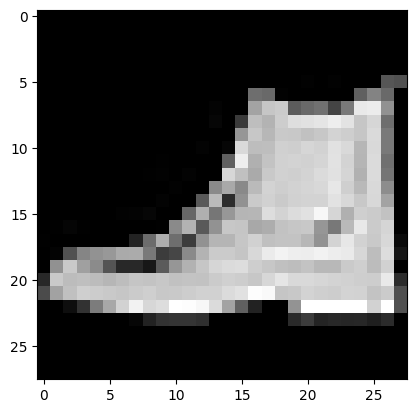

In [110]:
plt.imshow(image[0].squeeze(),cmap="gray")

In [111]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=cnn.parameters(),lr=0.01)

In [112]:
def train_function(model,data,loss_function,optimizer,accuracy):
  model.train()
  final_loss = 0
  final_accuracy = 0

  for batch,(image,lable) in enumerate(data):

    logits = model(image)

    loss = loss_function(logits, lable)

    final_loss += loss.item()
    final_accuracy += accuracy(logits, lable)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  final_loss /= len(data)
  final_accuracy /= len(data)
  print(f"Final Training Loss : {final_loss} || Accuracy : {final_accuracy}")


In [113]:
def test_function(model,data,loss_function,accuracy):
  model.eval()
  final_loss = 0
  final_accuracy = 0

  with torch.inference_mode():
    for batch, (image, lable) in enumerate(data):

      logits = model(image)

      loss = loss_function(logits,lable)
      final_loss += loss.item()

      final_accuracy += accuracy(logits,lable)

    final_loss /= len(data)
    final_accuracy /= len(data)
    print(f"Final Testing Loss : {final_loss} || Accuracy : {final_accuracy}")



In [114]:
epoches = 5
for epoch in range(epoches):
  print("\n\t---------\n\t")
  print(f"Epoch : {epoch} : \n")
  train_function(cnn,train_dataloader,loss_function,optimizer,accuracy)
  print("\n\t")
  test_function(cnn,test_dataloader,loss_function,accuracy)



	---------
	
Epoch : 0 : 

Final Training Loss : 1.1642251227060954 || Accuracy : 0.5878666639328003

	
Final Testing Loss : 0.5984548200814488 || Accuracy : 0.7837460041046143

	---------
	
Epoch : 1 : 

Final Training Loss : 0.5256042811671893 || Accuracy : 0.8098499774932861

	
Final Testing Loss : 0.4829794904960992 || Accuracy : 0.8302715420722961

	---------
	
Epoch : 2 : 

Final Training Loss : 0.4343036661227544 || Accuracy : 0.8443333506584167

	
Final Testing Loss : 0.42994167817572054 || Accuracy : 0.8455471396446228

	---------
	
Epoch : 3 : 

Final Training Loss : 0.39557206995884575 || Accuracy : 0.8583333492279053

	
Final Testing Loss : 0.40673905301589175 || Accuracy : 0.8598242998123169

	---------
	
Epoch : 4 : 

Final Training Loss : 0.3726239452203115 || Accuracy : 0.8672000169754028

	
Final Testing Loss : 0.3804587395474934 || Accuracy : 0.8651158213615417


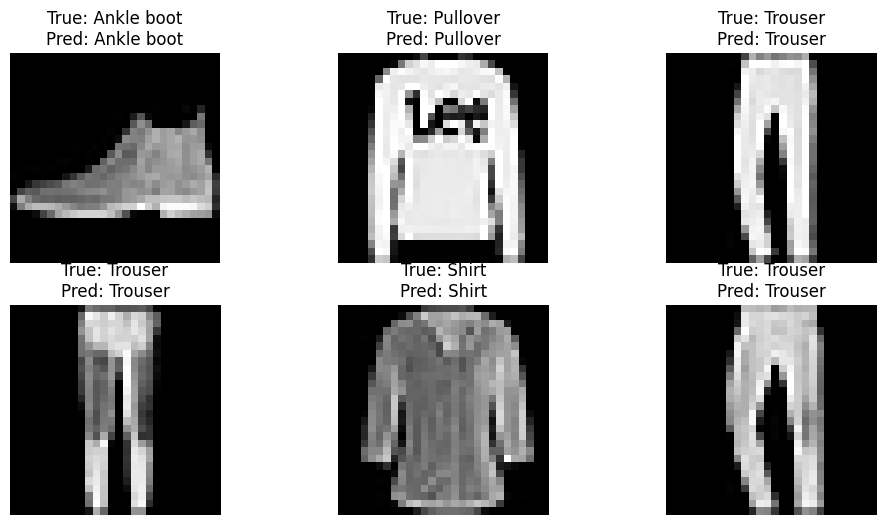

In [115]:
cnn.eval()
with torch.no_grad():
    images, labels = next(iter(test_dataloader))
    outputs = cnn(images)
    preds = outputs.argmax(dim=1)

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"True: {train_data.classes[labels[i]]}\nPred: {train_data.classes[preds[i]]}")
    plt.axis('off')
plt.show()